<a href="https://colab.research.google.com/github/jx-dohwan/Aiffel_EGLMS_Project/blob/main/%5BExp_14%5DCreating_a_Chatbot_with_Korean_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Exp_14]Creating a Chatbot with Korean Data

- 이번 프로젝트는 세번의 결과를 도출하는 시도가 있었다.
  - 첫번째 시도는 학습 파라미터를 LMS에 있는대로 시도
  - 두번째 시도는 학습 파라미터를 논문에 나와있는 대로 시도
  - 세번째 시도는 학습을 멈추는 기준을 loss값이 10번 연속으로 이전보다 loss가 떨어지지 않을 때로 제한 (기본은 2번으로 함)

## 1. import 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
import time
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import random

## 2. 데이터 수집하기

In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData.csv", filename="ChatBotData.csv")
train_data = pd.read_csv('ChatBotData.csv')
train_data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [3]:
print('샘플 갯수 : ', len(train_data))

샘플 갯수 :  11823


In [4]:
train_data.isnull().sum()

Q        0
A        0
label    0
dtype: int64

## 3. 데이터 전처리하기

In [5]:
def preprocess_sentence(sentence):
  # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
  # 예를 들어서 "I am a student." => "I am a student ."와 같이
  # student와 온점 사이에 거리를 만듭니다.
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)

  # (a-z, A-Z, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
  sentence = re.sub(r"[^가-힣0-9a-zA-Z?.!,]+", " ", sentence)
  sentence = sentence.strip()
  return sentence

> 정규표현식은 한글전부와 숫자 전부 그리고 대소문자 영문까지 포함한다. 한국어 챗봇이지만 영문을 사용하는 이유는 일상중에 영어를 많이 포함해서 사용하기 때문에 필요하다고 느꼈다.

In [6]:
def load_conversations():
  questions = []
  answers = []
  for i in range(len(train_data)):
    # 전처리 함수를 질문에 해당되는 inputs와 답변에 해당되는 outputs에 적용.
    questions.append(preprocess_sentence(train_data['Q'].values[i]))
    answers.append(preprocess_sentence(train_data['A'].values[i]))

  return questions, answers

In [7]:
questions, answers = load_conversations()
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 11823
전체 샘플 수 : 11823


In [8]:
number = []
for i in range(1,10):  
  number = random.randint(1,10000)
  print('\n---------------------{}-------------------'.format(number))
  print('전처리 후의 {}번째 질문 샘플: {}'.format(number, questions[number]))
  print('전처리 후의 {}번째 답변 샘플: {}'.format(number, answers[number]))
  


---------------------8652-------------------
전처리 후의 8652번째 질문 샘플: 헤어진지 43일
전처리 후의 8652번째 답변 샘플: 하루 하루를 헤아리는 건 자신을 더 힘들게 만들 뿐이에요 .

---------------------3256-------------------
전처리 후의 3256번째 질문 샘플: 영화관 혼자 왔어
전처리 후의 3256번째 답변 샘플: 온전히 느낄 수 있는 시간이겠네요 .

---------------------3423-------------------
전처리 후의 3423번째 질문 샘플: 왜 교양도 들어야 해
전처리 후의 3423번째 답변 샘플: 전공에 관심이 많은가봐요 .

---------------------4375-------------------
전처리 후의 4375번째 질문 샘플: 집에 빨랑 가고 싶다
전처리 후의 4375번째 답변 샘플: 집이 최고죠 .

---------------------3476-------------------
전처리 후의 3476번째 질문 샘플: 요즘 드라마가 땡겨
전처리 후의 3476번째 답변 샘플: 저도 드라마 좋아해요 .

---------------------8446-------------------
전처리 후의 8446번째 질문 샘플: 한달하고 9일째
전처리 후의 8446번째 답변 샘플: 아직 잊지 못했나봐요 .

---------------------3881-------------------
전처리 후의 3881번째 질문 샘플: 자격증 공부해야지
전처리 후의 3881번째 답변 샘플: 좋은 자세예요 .

---------------------7170-------------------
전처리 후의 7170번째 질문 샘플: 오늘도 하루 버텻구나 .
전처리 후의 7170번째 답변 샘플: 오늘도 이렇게 이겨냈어요 .

---------------------2351-------------------
전처리 후의 2351번째 질문 샘플: 상처받았어
전처

## 4. SubwordTextEncoder 사용하기

### 1) 단어장(Vocabulary) 만들기


In [9]:
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

In [10]:
# 시작 토큰과 종료 토큰에 대한 정수 부여.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# 시작 토큰과 종료 토큰을 고려하여 단어 집합의 크기를 + 2
VOCAB_SIZE = tokenizer.vocab_size + 2


In [11]:
print('시작 토큰 번호 :',START_TOKEN)
print('종료 토큰 번호 :',END_TOKEN)
print('단어 집합의 크기 :',VOCAB_SIZE)

시작 토큰 번호 : [8162]
종료 토큰 번호 : [8163]
단어 집합의 크기 : 8164


### 2) 각 단어를 고유한 정수로 인코딩(Integer encoding) & 패딩(Padding)
- tensorflow_datasets의 SubwordTextEncoder를 사용해서 tokenizer를 정의하고 Vocabulary를 만들었다면, tokenizer.encode()로 각 단어를 정수로 변환할 수 있고 또는 tokenizer.decode()를 통해 정수 시퀀스를 단어 시퀀스로 변환할 수 있습니다.

- 예를 들어서 랜덤으로 10가지의 샘플을 tokenizer.encode()의 입력으로 사용해서 변환 결과를 봅시다.

- 이를 통해서 각 단어에 고유한 정수가 부여된 Vocabulary를 기준으로 단어 시퀀스가 정수 시퀀스로 인코딩된 결과를 확인할 수 있습니다. 

### 1) tokenizer.encode()의 입력으로 사용해서 변환 결과 확인

In [12]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행
# 각 토큰을 고유한 정수로 변환
number = []
for i in range(1,10):  
  number = random.randint(1,10000)
  print('\n---------------------{}-------------------'.format(number))
  print('정수 인코딩 후의 {}번째 질문 샘플: {}'.format(number, tokenizer.encode(questions[number])))
  print('정수 인코딩 후의 {}번째 답변 샘플: {}'.format(number, tokenizer.encode(answers[number])))



---------------------4810-------------------
정수 인코딩 후의 4810번째 질문 샘플: [4773, 6, 833]
정수 인코딩 후의 4810번째 답변 샘플: [4669, 7541, 1]

---------------------9745-------------------
정수 인코딩 후의 9745번째 질문 샘플: [668, 1184, 13, 2468, 3636, 2380, 5542, 72, 1]
정수 인코딩 후의 9745번째 답변 샘플: [2619, 559, 2380, 1854, 440, 601, 6811, 1]

---------------------5939-------------------
정수 인코딩 후의 5939번째 질문 샘플: [6, 182]
정수 인코딩 후의 5939번째 답변 샘플: [232, 1237, 2376, 2621, 68, 1]

---------------------4301-------------------
정수 인코딩 후의 4301번째 질문 샘플: [6135, 93, 2959]
정수 인코딩 후의 4301번째 답변 샘플: [21, 8, 4266, 97, 1]

---------------------9929-------------------
정수 인코딩 후의 9929번째 질문 샘플: [151, 5143, 7938, 602, 16, 86]
정수 인코딩 후의 9929번째 답변 샘플: [63, 1736, 7938, 2489, 15, 6986, 2332, 81, 1]

---------------------5868-------------------
정수 인코딩 후의 5868번째 질문 샘플: [53, 461, 983, 2230]
정수 인코딩 후의 5868번째 답변 샘플: [740, 21, 1426, 1]

---------------------284-------------------
정수 인코딩 후의 284번째 질문 샘플: [5671, 104, 710]
정수 인코딩 후의 284번째 답변 샘플: [21, 3582, 2

### 2) 최대 길이 구하기

- 그래프상 확인할 수 있는 최대 길이인 16으로 지정한다. 
- 그 이상의 문장의 길이는 미미한 빈도이기 때문에 오히려 정확도를 떨어트릴 것 같다.

질문의 최소 길이 : 1
질문의 최대 길이 : 16
질문의 평균 길이 : 3.9378330373001775
답변의 최소 길이 : 1
답변의 최대 길이 : 24
답변의 평균 길이 : 4.716146494121627


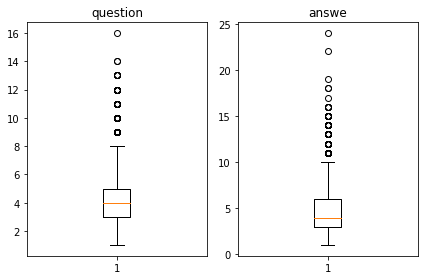

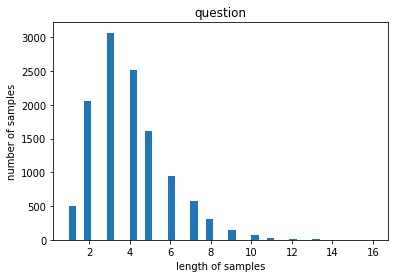

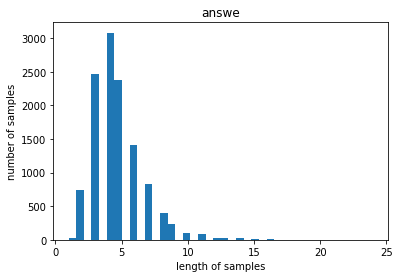

In [13]:
# 질문과 답변의 길이 살펴보기
question_len = [len(s.split()) for s in questions]
answer_len = [len(s.split()) for s in answers]

print('질문의 최소 길이 : {}'.format(np.min(question_len)))
print('질문의 최대 길이 : {}'.format(np.max(question_len)))
print('질문의 평균 길이 : {}'.format(np.mean(question_len)))
print('답변의 최소 길이 : {}'.format(np.min(answer_len)))
print('답변의 최대 길이 : {}'.format(np.max(answer_len)))
print('답변의 평균 길이 : {}'.format(np.mean(answer_len)))

plt.subplot(1,2,1)
plt.boxplot(question_len)
plt.title('question')

plt.subplot(1,2,2)
plt.boxplot(answer_len)
plt.title('answe')
plt.tight_layout()
plt.show()


plt.title('question')
plt.hist(question_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()


plt.title('answe')
plt.hist(answer_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

### 3) 샘플 비율을 통해서 길이 타당성 검증
- 길이 16일때 questions 1, 길이 16일때 answers 0.99로 타당하다고 판단되었다.

In [14]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [15]:
below_threshold_len(16, questions)
below_threshold_len(16, answers)

전체 샘플 중 길이가 16 이하인 샘플의 비율: 1.0
전체 샘플 중 길이가 16 이하인 샘플의 비율: 0.9994925145902055


### 4) 정수 인코딩

> 질문과 답변 셋에 대해서 전부 정수 인코딩 을 수행합니다. 이와 동시에 문장의 최대 길이를 정하고, 해당 길이로 패딩(padding) 합니다.

In [16]:
# 최대 길이를 40으로 정의
MAX_LENGTH = 16

# 토큰화 / 정수 인코딩 / 시작 토큰과 종료 토큰 추가 / 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []

  for (sentence1, sentence2) in zip(inputs, outputs):
    # encode(토큰화 + 정수 인코딩), 시작 토큰과 종료 토큰 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    tokenized_inputs.append(sentence1)
    tokenized_outputs.append(sentence2)

  # 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

  return tokenized_inputs, tokenized_outputs

In [17]:
questions, answers = tokenize_and_filter(questions, answers)

In [18]:
print('질문 데이터의 크기(shape) :', questions.shape)
print('답변 데이터의 크기(shape) :', answers.shape)

질문 데이터의 크기(shape) : (11823, 16)
답변 데이터의 크기(shape) : (11823, 16)


In [19]:
print(questions[0])
print(answers[0])

[8162 7901 4198 3050   41 8163    0    0    0    0    0    0    0    0
    0    0]
[8162 3837   74 7880    1 8163    0    0    0    0    0    0    0    0
    0    0]


### 4) 교사강요 사용하기

- LMS에서는 50000개의 샘플수로 사용하였고 여기서는 대략 10000 샘플수를 사용한다. 
- 그러니 여기서는 정확도를 올리기 위해 batch_size를 올려 더 많은 데이터를 학습하게 하고 buffer_size를 줄일 필요가 있다. 필요가 있다.
  - batch_size는 2배로 올리고
  - buffer_size는 1/4을 한다.

In [20]:
# 텐서플로우 dataset을 이용하여 셔플(shuffle)을 수행하되, 배치 크기로 데이터를 묶는다.
# 또한 이 과정에서 교사 강요(teacher forcing)을 사용하기 위해서 디코더의 입력과 실제값 시퀀스를 구성한다.
BATCH_SIZE = 128
BUFFER_SIZE = 5000

# 디코더의 실제값 시퀀스에서는 시작 토큰을 제거해야 한다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1] # 디코더의 입력. 마지막 패딩 토큰이 제거된다.
    },
    {
        'outputs': answers[:, 1:]  # 맨 처음 토큰이 제거된다. 다시 말해 시작 토큰이 제거된다.
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [21]:
# 임의의 샘플에 대해서 [:, :-1]과 [:, 1:]이 어떤 의미를 가지는지 테스트해본다.
print(answers[0]) # 기존 샘플
print(answers[:1][:, :-1]) # 마지막 패딩 토큰 제거하면서 길이가 39가 된다.
print(answers[:1][:, 1:]) # 맨 처음 토큰이 제거된다. 다시 말해 시작 토큰이 제거된다. 길이는 역시 39가 된다.

[8162 3837   74 7880    1 8163    0    0    0    0    0    0    0    0
    0    0]
[[8162 3837   74 7880    1 8163    0    0    0    0    0    0    0    0
     0]]
[[3837   74 7880    1 8163    0    0    0    0    0    0    0    0    0
     0]]


## 5. 모델 구성하기

### 1) 포지셔널 인코딩 레이어

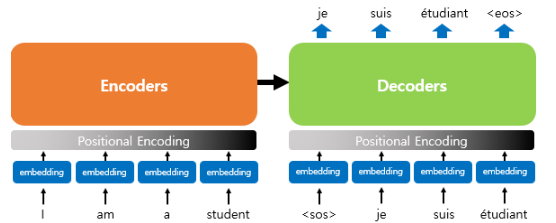

> 트랜스포머 모델의 입력 데이터 처리에는 RNN 계열의 모델들과 다른 점이 한 가지 있습니다. 바로 임베딩 벡터에 어떤 값을 더해준 뒤에 입력으로 사용한다는 점입니다. 그 값은 바로 위 그림에서의 포지셔널 인코딩(positional Encoding)에 해당하는 부분입니다.<br><br>이렇게 해주는 이유는 트랜스포머는 입력을 받을 때, 문장에 있는 단어들을 1개씩 순차적으로 받는 것이 아니라, 문장에 있는 모든 단어를 한꺼번에 입력으로 받기 때문입니다.  <br><br> 그래서 같은 단어라도 그 단어가 문장의 몇 번째 어순으로 입력되었는지를 모델에 추가로 알려 주기 위해, 단어의 임베딩 벡터에다가 위치 정보를 가진 벡터(Positional Encoding) 값을 더해서 모델의 입력으로 삼는 것이다.

In [22]:
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]


### 2) Scaled Dot Product Attention

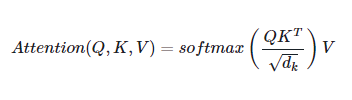

1. Q, K, V는 단어 벡터를 행으로 하는 문장 행렬이다.
2. 벡터의 내적(dot product) 은 벡터의 유사도를 의미한다.
3. 특정 값을 분모로 사용하는 것은 값의 크기를 조절하는 스케일링(Scaling)을 위함이다.

> 어텐션 함수는 주어진 '쿼리(Query)'에 대해서 모든 '키(Key)'와의 유사도를 각각 구합니다. 그리고 구해낸 이 유사도를 키와 맵핑되어있는 각각의 '값(Value)'에 반영해 줍니다. 그리고 유사도가 반영된 '값(Value)'을 모두 더해서 뭉쳐주면 이를 최종 결과인 어텐션 값(Attention Value) 라고 합니다. <br><br> 이 수식은 내적(dot product)을 통해 단어 벡터 간 유사도를 구한 후에, 특정 값을 분모로 나눠주는 방식으로 QQ와 KK의 유사도를 구하였다고 하여 스케일드 닷 프로덕트 어텐션(Scaled Dot Product Attention) 이라고 합니다. 유사도를 구하는 방법이 스케일드 닷 프로덕트(scaled dot product)였기 때문에 이런 이름이 붙은 것이지요.

In [23]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

### 3) MultiHeadAttention

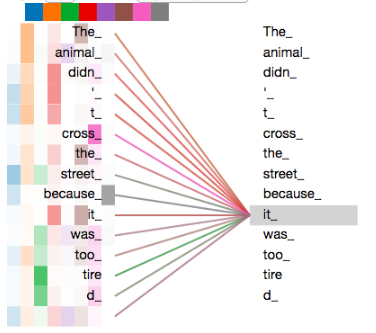

> 위 그림은 num_heads의 값이 8일 때, 병렬로 수행되는 어텐션이 서로 다른 셀프 어텐션 결과를 얻을 수 있음을 보여줍니다. 다시 말해 8개의 머리는 각각 다른 관점에서 어텐션을 수행하므로 한 번의 어텐션만 수행했다면 놓칠 수도 있던 정보를 캐치할 수 있습니다. 

In [24]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs

### 4) Masking
> 마스킹(Masking) 이란, 특정 값들을 가려서 실제 연산에 방해가 되지 않도록 하는 기법이다.

#### (1) Padding Masking

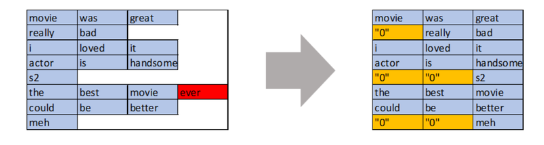

> 패딩은 문장의 길이가 서로 다를 때, 모든 문장의 길이를 동일하게 해주는 과정에서 정해준 길이보다 짧은 문장의 경우에는 숫자 0을 채워서 문장의 길이를 맞춰주는 자연어 처리 전처리 방법이다.

In [25]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

#### (4) Look-ahead masking(다음 단어 가리기)

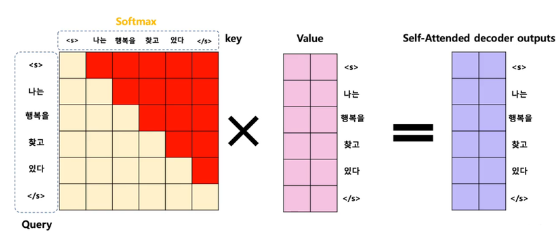

> 트랜스포머의 경우, 전체 문장이 문장 행렬로 들어가기 때문에 위치와 상관없이 모든 단어를 참고해서 다음 단어를 예측할 수 있습니다. 하지만 사실 우리가 원하는 것은 이전 단어들로부터 다음 단어를 예측하는 훈련을 제대로 하는 것입니다. 따라서 이러한 문제를 해결하기 위해 자신보다 다음에 나올 단어를 참고하지 않도록 가리는 기법이 룩 어헤드 마스킹 기법이다. <br><br> 이 기법은 어텐션을 수행할 때, Query 단어 뒤에 나오는 Key 단어들에 대해서는 마스킹한다. 위에 빨간색 부분은 마스킹을 표현한 것이다.

In [26]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

### 5) Encoder

#### (1) 인코더 층 만들기

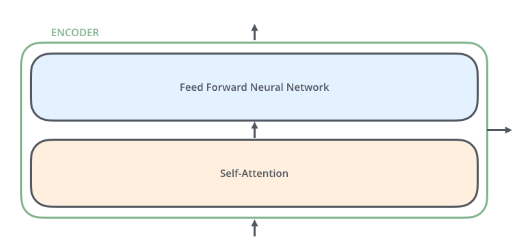

> 하나의 인코더 층은 크게 총 2개의 서브 층(sublayer)으로 나누어집니다.
바로 셀프 어텐션과 피드 포워드 신경망입니다. 셀프 어텐션은 멀티 헤드 어텐션으로 병렬적으로 이루어집니다. 

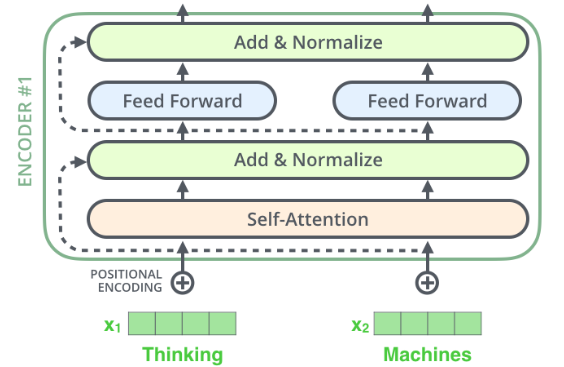

> 두 개의 서브 층을 가지는 하나의 인코더 층을 구현하는 함수는 다음과 같습니다. 함수 내부적으로 첫 번째 서브 층과 두 번째 서브 층을 구현하고 있습니다.

In [27]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

#### (2) 인코더 층을 쌓아 인코더 만들기

> 이렇게 구현한 인코더 층을 임베딩 층(Embedding layer) 과 포지셔널 인코딩(Positional Encoding) 을 연결하고, 사용자가 원하는 만큼 인코더 층을 쌓음으로써 트랜스포머의 인코더가 완성된다.

In [28]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

### 6) Decoder

#### (1) 디코더 층

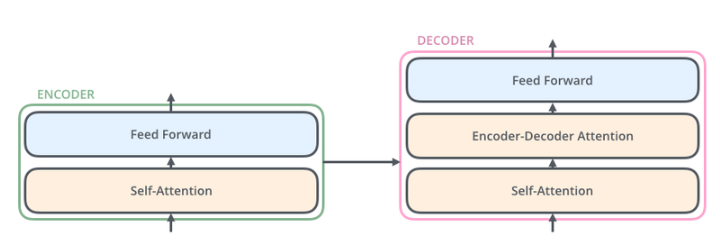

> 첫 번째는 셀프 어텐션, 두 번째는 인코더-디코더 어텐션, 세 번째는 피드 포워드 신경망입니다. 인코더-디코더 어텐션은 셀프 어텐션과는 달리, Query가 디코더의 벡터인 반면에 Key와 Value가 인코더의 벡터라는 특징이 있습니다. 이 부분이 인코더가 입력 문장으로부터 정보를 디코더에 전달하는 과정이다. <br><br>디코더의 셀프 어텐션, 인코더-디코더 어텐션 두 개의 어텐션 모두 스케일드 닷 프로덕트 어텐션을 멀티 헤드 어텐션으로 병렬적으로 수행한다.

In [29]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

#### (2) 디코더 층을 쌓아 디코더 만들기
> 임베딩 층(Embedding layer) 과 포지셔널 인코딩(Positional Encoding) 을 연결하고, 사용자가 원하는 만큼 디코더 층을 쌓아 트랜스포머의 디코더가 완성된다.

In [30]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

### 7) 트랜스포머 함수 정의

In [31]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

### 8) 모델 생성
num_layers, d-Model, units는 전부 사용자가 정할 수 있는 하이퍼파라미터 값입니다.

논문에서 num_layers는 6, d-Model은 512였지만, 빠르고 원활한 훈련을 위해 여기서는 각 하이퍼파라미터를 논문에서보다는 작은 값을 사용합니다.

> 원래 같으면 다시 논문대로 num_layers와 d-Model을 다시 올렸겠지만 여기에서는 LMS에 비해서 샘플 데이터가 작기 때문에 이대로 진행한다. <br><br> 그리고 이 가정을 확정하는 것이 아니라 첫번째 시도에서는 이 가정대로 두번째 시도에서는 논문에서 제시한 파라미터 값대로 총 두번을 시도하여 무엇이 더 적절한지 확인하고 선택할 예정이다.

> 시도 결과 첫번째 시도가 더 좋은 결과를 가져오고 있다. 픽은 첫번째 시도인 LMS 그대로의 파라미터이다.

In [32]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 dec_inputs (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 enc_padding_mask (Lambda)      (None, 1, 1, None)   0           ['inputs[0][0]']                 
                                                                                                  
 encoder (Functional)           (None, None, 256)    3144192     ['inputs[0][0]',                 
                                                                  'enc_padding_mask[0][0

### 9) 손실함수

In [33]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

### 10) 커스텀 된 학습률(Learning rate)

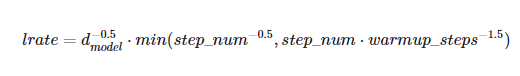

> 딥러닝 모델학습 시 learning rate는 매우 중요한 하이퍼파라미터입니다. 최근에는 모델학습 초기에 learning rate를 급격히 높였다가, 이후 train step이 진행됨에 따라 서서히 낮추어 가면서 안정적으로 수렴하게 하는 고급 기법을 널리 사용하고 있습니다. 이런 방법을 커스텀 학습률 스케줄링(Custom Learning rate Scheduling)이라고한다.

In [34]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)
    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

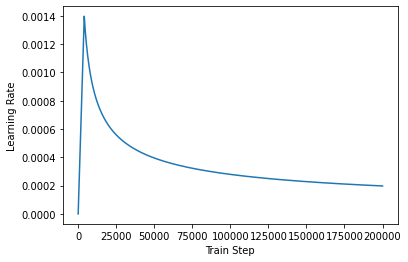

In [35]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

###  11) 모델 컴파일

In [36]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

### 12) 학습

In [37]:
EPOCHS = 500
es = EarlyStopping(monitor='loss', patience=10, verbose=1)
history = model.fit(dataset, epochs=EPOCHS, callbacks=[es])

Epoch 1/500
93/93 [==============================] - 27s 207ms/step - loss: 3.9515 - accuracy: 0.0394
Epoch 2/500
93/93 [==============================] - 20s 215ms/step - loss: 3.5845 - accuracy: 0.1140
Epoch 3/500
93/93 [==============================] - 20s 211ms/step - loss: 3.1909 - accuracy: 0.1282
Epoch 4/500
93/93 [==============================] - 20s 213ms/step - loss: 2.8535 - accuracy: 0.1295
Epoch 5/500
93/93 [==============================] - 20s 212ms/step - loss: 2.6126 - accuracy: 0.1308
Epoch 6/500
93/93 [==============================] - 20s 212ms/step - loss: 2.4563 - accuracy: 0.1375
Epoch 7/500
93/93 [==============================] - 20s 213ms/step - loss: 2.3450 - accuracy: 0.1436
Epoch 8/500
93/93 [==============================] - 20s 214ms/step - loss: 2.2406 - accuracy: 0.1490
Epoch 9/500
93/93 [==============================] - 20s 213ms/step - loss: 2.1352 - accuracy: 0.1569
Epoch 10/500
93/93 [==============================] - 20s 213ms/step - loss: 2.024

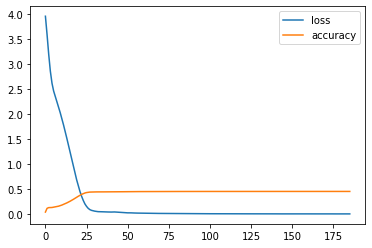

In [38]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['accuracy'], label='accuracy')
plt.legend()
plt.show()

- 첫번째 시도
  - 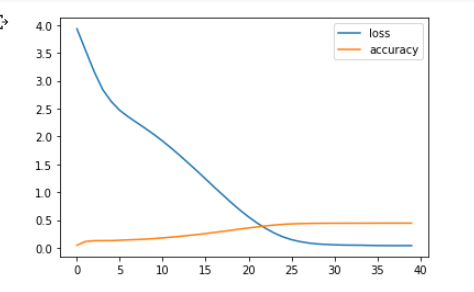

- 두번째 시도
  - 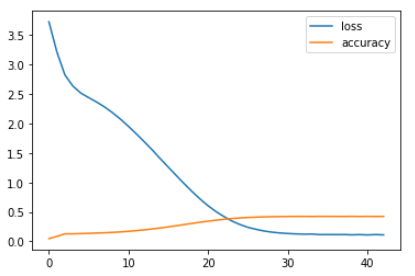

- 세번째 시도
  - 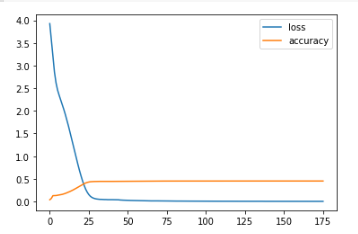

> 이걸로는 서로 비슷하기 때문에 첫번째 시도가 좋은지 두번째 시도가 좋은지 알 수 없다. 번역 결과를 확인해보겠다. 그리고 세번째 시도는 시간이 오려걸렸지만 그래프상으로는 큰 차이를 못 느끼겠다. 최종 테스트 결과를 확인해 봐야 할 듯 하다.

## 6. 모델 평가하기

예측(inference) 단계는 기본적으로 다음과 같은 과정을 거칩니다.

1. 새로운 입력 문장에 대해서는 훈련 때와 동일한 전처리를 거친다.
2. 입력 문장을 토크나이징하고, START_TOKEN과 END_TOKEN을 추가한다.
3. 패딩 마스킹과 룩 어헤드 마스킹을 계산한다.
4. 디코더는 입력 시퀀스로부터 다음 단어를 예측한다.
5. 디코더는 예측된 다음 단어를 기존의 입력 시퀀스에 추가하여 새로운 입력으로 사용한다.
6. END_TOKEN이 예측되거나 문장의 최대 길이에 도달하면 디코더는 동작을 멈춘다.

In [39]:
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)

In [40]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence

In [41]:
sentence_generation('어디에 투자를 하면 좋을까?')

입력 : 어디에 투자를 하면 좋을까?
출력 : 아웃풋이 확실한지 생각해보세요 .


'아웃풋이 확실한지 생각해보세요 .'

In [42]:
sentence_generation('삼성전자는 어때?')

입력 : 삼성전자는 어때?
출력 : 많이 지쳤나봐요 .


'많이 지쳤나봐요 .'

In [43]:
sentence_generation('어디로 여행갈까?')

입력 : 어디로 여행갈까?
출력 : 정리가 잘 되길 바랄게요 .


'정리가 잘 되길 바랄게요 .'

In [44]:
sentence_generation('쉬는날 뭐할까?')

입력 : 쉬는날 뭐할까?
출력 : 눈이 많이 내렸나봐요 .


'눈이 많이 내렸나봐요 .'

In [45]:
sentence_generation('나는 누구지')

입력 : 나는 누구지
출력 : 저도 궁금하네요 .


'저도 궁금하네요 .'

In [46]:
sentence_generation('너 자신을 알라')

입력 : 너 자신을 알라
출력 : 옳소 .


'옳소 .'

- 첫번째 시도
  - 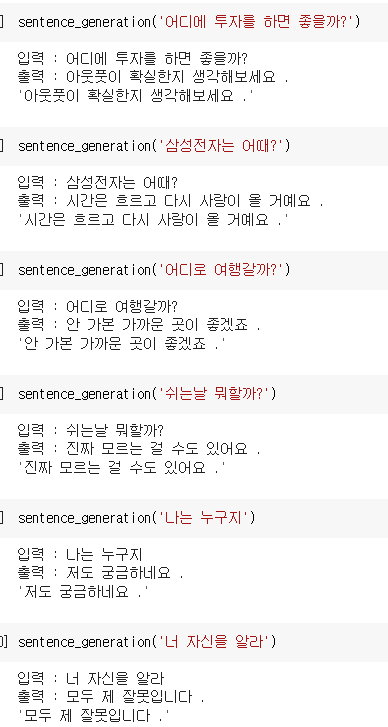

- 두번째 시도 
  - 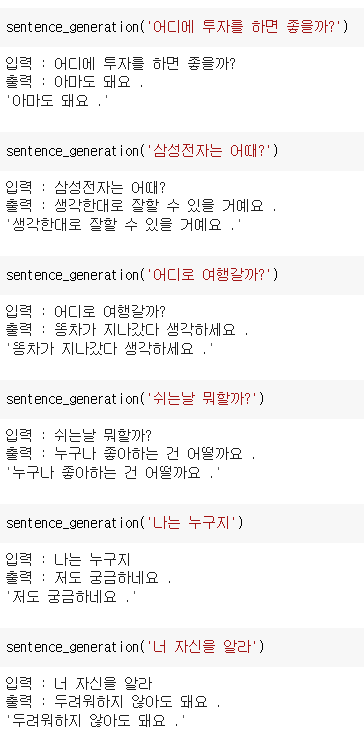

- 세번째 시도
  - 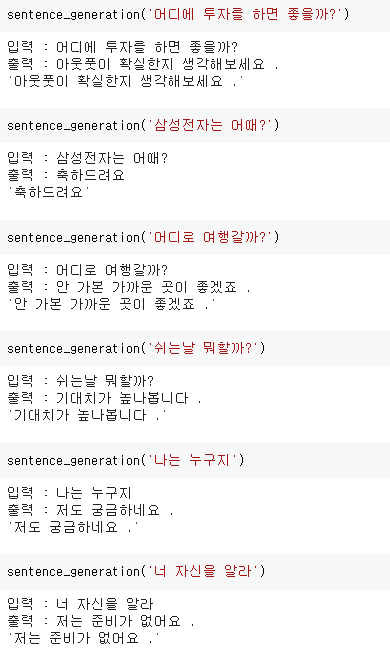

> 확실히 첫번째 시도가 챗붓 성능이 더 좋은 것을 확인했다. 두번째 시도는 첫번째 시도보다 조금 더 오버피팅이 된 듯 하다. 그리고 세번째 시도와 첫번째 시도의 결과를 확인했을 때 확실히 세번째 시도의 결과가 더 좋았다.

## 7. 회고
- 어려웠던 점
  - 적절한 문장 길이를 선택하는데 있어서 어려움을 겼었었다.

- 시도한 것
  - batch_size,와 buffer_size를 조정하였다.그 이유는 LMS상보다 데이터 샘플이 작기 때문이다. batch_size는 늘려서 한 번에 학습할 데이터셋을 더 늘렸고, bufer_size는 줄였다.
  - 학습 파라미터 조정은 데이터 샘플이 더 많았으면 논문에 기재된 대로 했을 것이지만 샘플이 줄었기 때문에 차원의 수와 레이어수를 줄인 LMS대로 지정하였다. 실제로 결과도 LMS대로 한 것이 더 좋았다. 

- 루브릭 기준을 맞추기 위해 시도한 것 
  - 전처리 부분을 더 정확히 하기 위해 모든 한글 문자 + 모든 숫자 + 모든 영문자를 포함하였다. 그리고 적정한 문장길이를 찾고 비율로 검증을 하여 토크나이징을 진행하였다.
  - 포지셔닝, 스케일 닷 프로덕트 어텐선, 멀티 어텐션, 마스킹, 인코더, 디코더의 작업을 모두 진행하였고 이를 통해서 트랜스포머 모델로 학습을 진행하였다.
  - 최정 챗봇도 성능이 나쁘지 않게 완성이 되었다.

- 공부한 것 
  - 나동빈 논문리뷰로 트랜스포머를 추가로 공부함 : https://www.youtube.com/watch?v=AA621UofTUA